In [64]:
# 画像保存用の setting
PROJECT_ROOT_DIR = "."

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "figures", "HandsOnCh2" + fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

Hands-On Machine Learning with Scikit-Learn and TensorFlowを読んでいます．
読んだところをまとめ．

# Working with Real Data
不動産会社のデータサイエンティストになったと思って，データ分析してみましょうというストーリー．real-world dataを使いたいということで，今回はCalifornia Housing Prices datasetを使います．著者のGitHubから落とせます．(./datasets/housingにあります．housing.csvというファイル．)

# Look at the Big Picture
最初のタスクはカリフォルニア州の調査データからカリフォルニアの住宅価格のモデルを作ることです！このデータには人口，所得の中央値，住宅価格の中央値などがカリフォルニアの地区ごとに収録されてます．その地区はUS Census Breauが提供している最小単位だそう．めんどいので"districts"と呼びます．

## Frame the Problem
ボスに最初に聞いとかなきゃいけないのは”ビジネスの目的はなんだい？”ってこと．その回答からこれから作るモデルを会社がどう使って利益を生み出すかということがわかる．ボスの答えは，あなたが作ったモデルの出力が別の機械学習システムに入力されて，最終的にはある地区に投資すべきか否かを判断するのに使うってこと．

次にする質問は，"現状はどうなん？"という質問．この質問に対する回答で参照するべきベンチマークと，問題をどう解決するかの参考情報がわかる．現状は地区ごとの住宅価格が専門家の手作業で作られているようだ．
こいつはコストもかかるし時間もかかる．彼らの算出値もあやしい．これが理由で会社はデータを使って住宅価格を出そうとしているようだ．

以上の情報を元に，frame the problemをしてみよう．
-　教師あり学習？教師なし学習？強化学習？
-　分類問題？回帰問題？それ以外の問題？
-　バッチ学習？オンライン学習？
下に回答が書いてあるけど，それを見る前に自分で考えてみよう．

答え：
- 教師あり学習(訓練データがすでにある)
- 多変量回帰問題(目は予測値を出すというタスク)
- バッチ学習(データの規模は小さい)

## Select a Performance Measure
いろんな評価指標が書いてある．数式の意味は省略．
- RMSE(Root Mean Square Error)
- MAE(Mean Absolute Error)
高次のノルムの方が大きな値から影響を受け，小さな値からの影響は小さくなる点に注意．なので，RMSEはMAEより外れ値(outlier)の影響を受けやすい．ただし，外れ値があまりなく，分布がベルカーブになっていたらRMSEの方が好まれます．

## Check the Assumptions
分析．データの前提をリストアップして検証しとくのはいいことだ．これから作るモデルの出力である地区ごとの住宅は次の機械学習システムに入力されるけど，後工程のシステムは価格を"安い"，"普通"，"高い"というカテゴリーに分けてたらどうでしょう．住宅価格の計算精度を完璧にする意味ないよね？モデルも分類問題として扱った方がよさそう．
今回の例では住宅価格をそのまま使ってるそうなので，回帰問題としてモデルを立てていきましょう．

# Get the Data
## Create the Workspace
インストールの解説はめんどいのでjupyterが使える前提で話を進めます．
著者のGitHubではなく，自分のGitHubでやってる感じで以下は書いていきます．
## Download the Data

In [65]:
import os
import pandas as pd

HOUSING_PATH = "datasets/housing"
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path,"housing.csv")
    return pd.read_csv(csv_path)

## Take a Quick Look at the Data Structure
head()を使って取得したデータをちょっと覗いてみよう．
なぜかテキストでは画像貼り付けになっているけど，以下のコードを実行．

In [66]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


各行が1レコード=1地区になっていて，それぞれ10個の属性を持ってます．10個は以下の感じ：longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households, median_income, median_house_value, ocean_proximity．
info()を使うとデータの詳細が見れます：

In [67]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [68]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

これで内容が見れます．
あと，describe()で量的情報のまとめを出力できます．

In [69]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Null値は無視されるのでtotal_bedroomsの数が20433になっている．
stdは標準偏差，%の値はN%点を表す(たとえば25%は下から数えて25%点に対応する値が表示される)．

扱っているデータの感覚を掴むためには，もうひとつ別に，ヒストグラムを書いて見るといい．
以下のコードを実行する．

Saving figure figure2-1


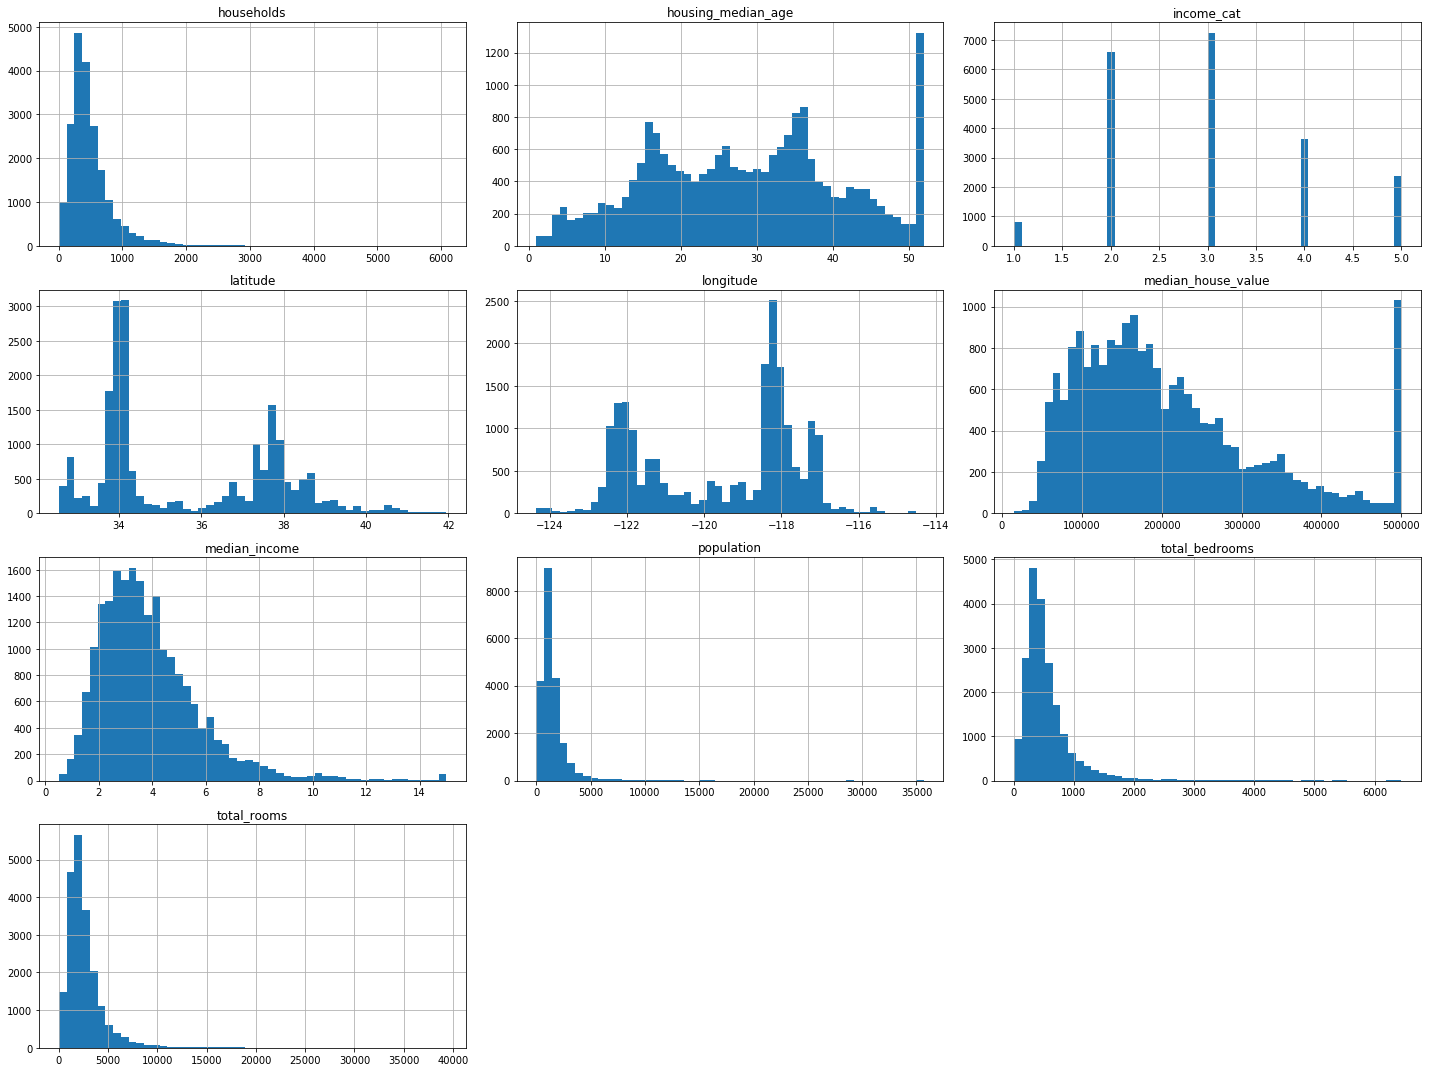

In [80]:
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
save_fig("figure2-1")
plt.show()

ヒストグラムからわかること
1. median incomeがUSDで表示されていない可能性がある(桁が小さすぎる)．調べてみたところ，スケールか収入がスケール化されていて，最大15最小0.5に制限がかけられている．
2. housing median ageとmedian house valueも最大値が設定されている．後者は分析の出力となる目標変数なので問題だ，作ったモデルの出力値がこの最大値を声なくなってしまう．クライアントチームと話して，これが問題か議論する必要がある．よくある解決策は以下の2つ：
a. 適切なラベルを集めてくる
b. この地区のラベルを消す
3. これらの変数はスケールが全く異なっている．
4. 多くのヒストグラムで分布の裾が厚くなっている(medianよりも右側にサンプルが多くなっている)．あとでベル型の分布に変換する方法を考える．

[test setを作る]
この段階で訓練データとテストデータを分けておきます．
作り方：ランダムにいくつかのインスタンスを抽出して(今回は20%)，訓練データから除けておく．

In [71]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [72]:
train_set , test_set = split_train_test(housing, 0.2)
print(len(train_set), " train + ", len(test_set), "test")

16512  train +  4128 test


これでもいいけど問題あり．
→もう一回実行するとテストデータが変わって(ランダムなので)，前回とは別の結果ができてしまう(再現性がない)
そういうときは次のようにするといい．
1. 最初に作った訓練データとテストデータをとっておく
2. np.random.seed(42)などとしてシードを固定すればOK

ただし上の方法は新しいデータセットを加える時に崩壊する．
共通の解決策はテストデータに行くか訓練データに行くか決めるインデックスをつくること．
こうすることで何回も計算を回してもテストデータはいつも変わらない(=consistent)ようにすることができる．

In [73]:
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids=data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

ただし，housingデータセットはID列をもたないので，行番号をIDに使うことにします．

In [74]:
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

行番号をユニークなIDとして使う場合は，新しいデータを既存のデータセットの最後に追加すること，途中の行を削除しないことを確実にしないといけない．
これができないのであれば，変更がなさそうな変数を使ってユニークなIDを作ればいい．
たとえば，地区のlatitudeと　longitudeは変わらなそうなので，これらをくっつけてIDを作る．

In [75]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

Scikit-Learnはデータをいくつかのsubsetsに分解する関数をいくつか用意している．
ここではtrain_test_split を紹介．一番簡単な関数でさっきのsplit_train_testと同じことを，追加のオプションをつけて使える．
オプションの一つに random_state パラメータというのがあって，このオプションでさっきのシードを指定できる．
もう一つの特徴として，行数が同一のデータセットを複数入力することができて，同じインデックスで入力した複数のデータセットを分割することができる．

In [76]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

ここまでランダムなサンプルを考えてきたけど，この方法だとサンプリングバイアスがかかってしまう．
母集団を,strataと呼ばれる同質なsubgroupに分解する層化抽出(stratified sampling)を使えば，テストデータが母集団全体をうまく表すことができるようになる．

median income がmedian housing pricesを予測するのにとても重要な変数である場合，データ全体の収入の各カテゴリをうまく代表してくれているテストデータを作れると嬉しい！このためには各stratumに十分なサンプルが含まれるように層を分けなければならない．言い換えれば，あまり多くの層に分けてしまってはいけないということになる．

In [77]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

In [78]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [79]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

# やること
Figure 2-10をつくる

最後に"income_catを消す．
あと，結構な時間をテストデータの作成に費やしたけれども，機械学習プロジェクトでは見過ごされがちだがとても重要な部分なんですよ．

In [17]:
for set_ in (strat_train_set,strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Discover and Visulalize the Data to Gain Insights
訓練データを使ってデータの可視化をしてみよう．
## Visualizing Geographical Data

Saving figure figure2-2


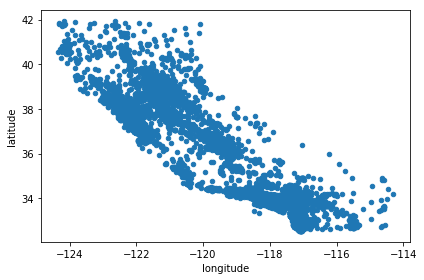

In [81]:
housing = strat_train_set.copy()
housing.plot(kind="scatter", x="longitude", y="latitude")
save_fig("figure2-2")
plt.show()

データ数が多いところを濃くすると見分けがつきやすい．
パラメータalphaを設定するとできる．

Saving figure figure2-3


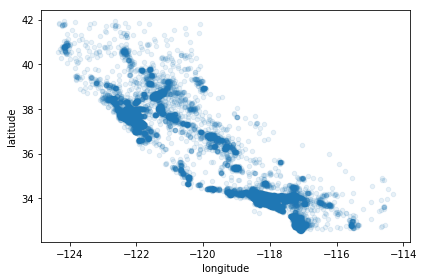

In [82]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("figure2-3")
plt.show()

　人間の脳は画像情報からパターンを認識する能力が高いんだけど，ここではいろんなパラメータをいじってみよう！
 - パラメータs：丸の直径が各サンプル点の人口を表すようにする
 - パラメータc：色で価格を表すようにする
-  パラメータcmap：cの色に既定カラーセットを使う

Saving figure figure2-4


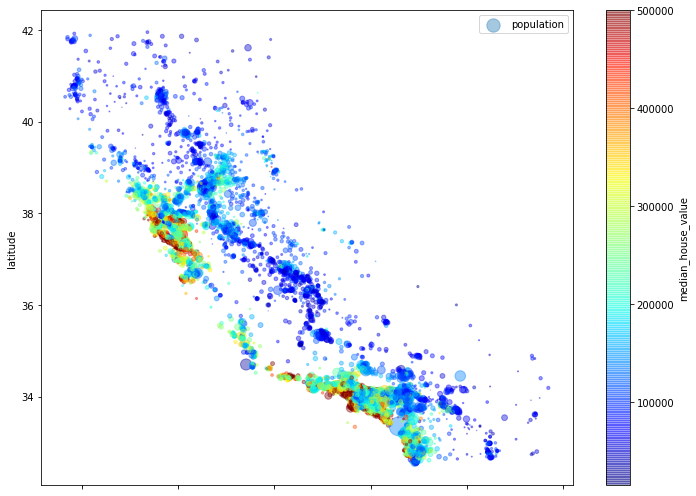

In [83]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, s=housing["population"]/100, label="population", figsize=(10,7), c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
save_fig("figure2-4")
plt.show()
plt.legend()

このプロットを使えば，クラスタリングとかに使えそう．
## Looking for Correlation

In [84]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
income_cat            0.642274
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

pandasを使って相関の散布図を作るとさらに便利

/Users/syuheyk/.pyenv/versions/anaconda3-4.3.1/envs/py3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Saving figure figure2-5


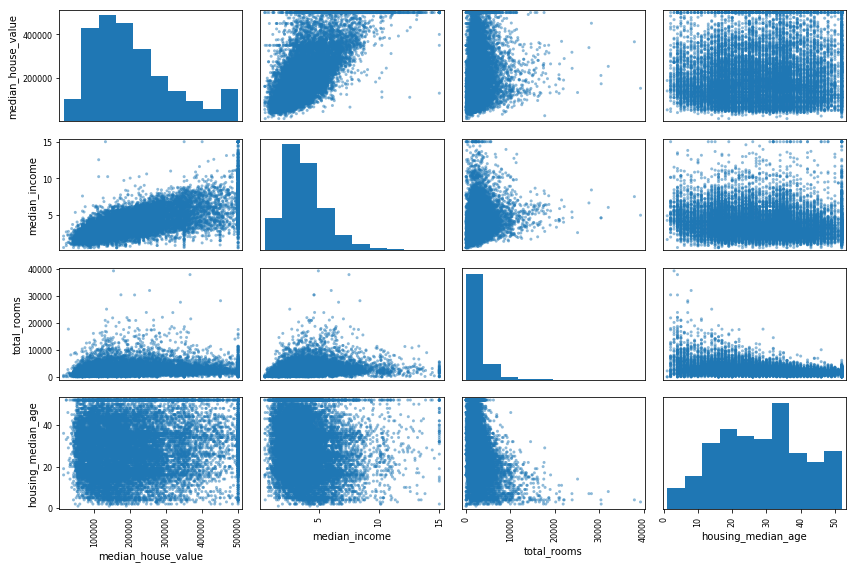

In [86]:
from pandas.tools.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))
save_fig("figure2-5")
plt.show()

対角成分は相関を出力してもしかたがないので，それぞれの変数のヒストグラムが表示されます．
median_house_valueの予測に一番重要な変数はmedian_incomeなのでこいつだけ取り出してみてみよう．

Saving figure figure2-6


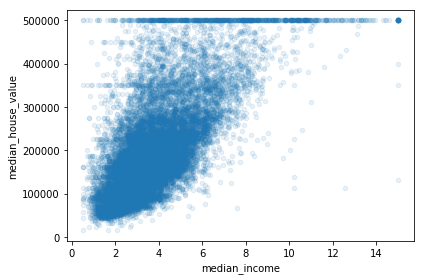

In [23]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)
save_fig("figure2-6")
plt.show()

このプロットからわかること
1. 確かに相関は高い(全体的に右上がりの傾向がみれるでしょ？)
2. 価格の最大値の制限がはっきりわかる(median_house_value=500kのところで横線になってる．よくみると350kや450kのあたりにも横線っぽいのがでている．→こういうデータ特性をモデルが出力しないようにするために，これらのデータを取り除いておくというのは一つの手です．

## Experimenting with Attribute Combinations
これまでのデータ可視化で取り除きたいデータのくせや裾の厚い分布が変数に含まれていることがわかりました．
最後の分析前の下処理として，変数を組み合わせてこうした特徴を消しましょう．
たとえば，
- total_rooms自体が大事なのではなくて，number_of_rooms_per_houseoldが大事なんだ
- total_bedroomsが大事なんじゃなくてbedrooms_per_roomが大事なんだ
- pupulation自体が大事なんじゃなくてpopulation_per_householdが大事なんだ
などです．これをやってみよう．

In [24]:
housing["rooms_per_household"]=housing["total_rooms"]/housing["households"]
housing["bedrooms_per_rooms"]=housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_rooms         -0.259984
Name: median_house_value, dtype: float64

Hay, not bad!だそうです．bedrooms_per_roomはtotal_roomsやtotal_bedroomsより高いもmedian_house_valueとの相関になっています．
(明らかに部屋数/ベッド数の比率が低い方が高いでしょ？)
同じような理由でtotal_roomsよりrooms_per_householdの方が情報持っているというのも理解できるでしょう．

こういった探索を完全に行う必要はないです．
大事なことは，早く手をつけてインサイトを集めることが合理的で良いプロトタイプを作ることにつながるってこと．
ただしこれは継続的なプロセスであって，一旦プロトタイプを作ってモデルを作ったとしても，その出力を分析してまたデータの探索ステップに戻る必要があります．

# Prepare the Data for Machine Learning Algorithms
データを用意する代わりに，それをする関数を書きましょう．以下のようなメリットがあります
- どんなデータセットに対しても簡単に再変換できます．
- 再利用可能な変換関数のライブラリを作ることができます．
- システムで使えます．
- いくつかの変換を簡単にトライすることができます．
(説明)変数とラベルに同じ変換をする必要はないので，これらを分けましょう．

In [25]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

## Data Cleaning
total_bedroomsに欠損があるので，まずはこれを直します．オプションは以下の3つ
 1. 抜けてる地区(1レコード全部)を消します：dropna()
 2. 変数自体を消します：drop()
 3. なにかの値を入れます：fillna()
 オプション3でmedianなどを採用した場合，　計算した値(median)を保存しておくのを忘れずに．あとでテストデータを使うときとか，新しいデータがきたときに使います．

In [26]:
# option1
  # housing.dropna(subset=["total_bedroooms"])
# option 2
  # housing.drop("total_bedroooms",axis=1)
# option 3
  # median = housing["total_bedrooms"].median()
  # housing["total_bedrooms"].fillna(median, inplace = True)

オプション3を採用するときは，Scikit-Learnには欠損値を扱う便利なクラス：Imputerがあります．
最初にImputerクラスを作り，リプレイスしたい変数をしていします．
(この操作はデータに関係ない)

In [27]:
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median")

変数ocean_proximityはテキスト変数なのでmedianを計算できないため，これを外してからImputerに入れます．
Imputerに入れるにはfit()を使います．

In [28]:
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

imputerが計算した値(今回はmedian)はstatistics_メソッドでとれます．
さっき見た感じtotal_bedroomsだけに欠損値がありましたが，新しく入ったデータの他の変数に欠損があるかもしれないので，全部の変数のmedianを取っておくのが安全です．

In [29]:
imputer.statistics_

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

In [30]:
housing_num.median().values

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

imputerで変換したデータセットを使ってモデルを作ります．
結果はNumpy配列になるのでpandasのDataFrameとして使うには，また変換する必要があります．

In [31]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

## Handling Text and Categorical Attributes
ocean_proximity変数は数値じゃないということで先ほど弾きましたが，テキストを数値に変換してみましょう．
Scikit-LearnにはLabelEncoderというクラスがあってこれができます．


In [32]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
print(housing_cat_encoded)
print(encoder.classes_)

[0 0 4 ..., 1 0 3]
['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


これは良いものですね．classes_メソッドで数値とテキストの対応も確認できます．
ただし一つ問題があって，機械学習のアルゴリズムは2つの値が近いということは2つの値が遠いよりも似ているという判断をします．
上の数値を使うと，0と4よりも0と1の方が近いサンプルと認識されてしまいますが，そんなことはないです．
この現象に対する解決策はone-hot encoding = 1 of K 符号化法を使うことです．
ScikitLearnでは OneHotEncoder を使うことで整数値カテゴリ変数をone-hotベクタに変更することができます．
fit_transform()は2次元配列，housing_cat_encodedは1次元配列なので配列を整形する必要があることに注意してください．

In [33]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

出力がSciPy sparce matrixになっていることに注意してください．この型は数千のカテゴリ変数を扱う時には便利ですし，ほとんど2次元配列として使えます．
しかし，諸々の事情からNumPyの密行列として扱いたいときは，toarray()関数を使います．

In [34]:
housing_cat_1hot.toarray()

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

ちなみに，以上の2つの変換をLabelBinalizerを使うと一発でできます．
注意点はこっちの関数はNumpyの密行列として出力されるので，sparce matrixにするにはsparse_output=Trueとオプションを設定します．

In [35]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ..., 
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

## Custom Transformers
Scikit-Learnでいくつか使いでのある変換関数を提供してるけど，自分で変換関数を書く必要があるシチュエーションに出会ったときにはどうすればいいでしょうか．
こんなときもfit(),transform(),fit_transform()関数を自分で作るクラスのメソッドに用意するだけでScikit_Learnの変換関数と同様に(pipelineとかで)使うことができます．最後のfit_transform()は基底クラスとしてTransformerMixinを追加すればＯＫです．
それと，BaseEstimatorを基底クラスとして追加するときは(そしてコンストラクタに *argsと **kargs　 に入れない)，get_params()とset_params()の2つの関数が使えます．これはhyperparameterを自動的にチューニングするときに便利な関数です．

例として，前述した変数の合成をする変換クラスを作成してみましょう．

In [36]:
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, household_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, bedrooms_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [37]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room = False)
housing_extra_attribs = attr_adder.transform(housing.values)

この例では，　add_bedrooms_per_roomというハイパパラメータがあります(規定値はTrue)．
このハイパパラメータを使えば，機械学習アルゴリズムでbedrooms_per_roomという変数を追加するべきか判定できるかも．

一般的に，データ準備の段階で100%確かにと思えないような変数を追加するかどうか選択するハイパパラメータを作れます．
データ準備段階で自動化すればするほど，変数のコンビを自動で試すことができます．
そうすれば，思いもかけなかった変数のコンビがより効率的に見つかるかもしれません．

## Feature Scaling
機械学習アルゴリズムは，インプットの数値変数がそれぞれ全然違うスケールになっていると，うまく動かない(いくつかの例外を除いて)．
これを調整するのがfeature scalig．以下の2つがよくある方法です．
1. min-mac scaling
値のレンジが0から1になるように，変数値のリスケールとシフトを行う．やり方は，最小値(min)を引いて，最大幅(max-min)で割る．Scikit-LearnではMinMaxScalerという変換クラスを使ってこのスケーリングができる．このクラスはfeature_rangeというハイパパラメータを持っていて，レンジの長さを0-1にしたくないときはこのパラメータを使える．
2. standardization
変数値から平均(mean)を引いて，標準偏差(テキストではvarianceと書いてあるがstandard deviationの間違いと思われる)で割る方法．なので変換後の変数は平均0，分散1になる．min-max scalingと違い，変数値が特定のレンジに収まらないのでneural networkなどの0-1の間の値をインプットにしたいようなアルゴリズムには適さない変換．しかし，外れ値に対して影響を受けにくくなるという特徴がある．Scikit-LearnではStandardScalerという変換クラスを使ってできる．

## Transformation Pipelines
いろんな変換を正しい手順で行わなければならないんですが，Scikit-LearnのPipelineクラスというのを使って実装の手助けをしてもらえる．

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', Imputer(strategy="median")),
    ('attribsadder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

Pipelineのコンストラクタは手順を流れを定義した name/estimator のペアのリストを引数にとる．ただし，最後以外のestimatorは変換じゃないといけない(=fit_transform()メソッドを持つ関数)．名前は二重のアンダースコアが入ってなければなんでもＯＫ！

(ややこしいが)Pipelineのfitが呼び出されると，Pipelineに定義されている手順通りに，まず最初のfit_transform()が呼び出され，その手順のアウトプットが次の手順のインプットに渡され，次の手順のfit_transform()が呼び出され．．．というのを最後の手順になるまで繰り返す．最後の手順はfit()を呼び出して終わる．

Pipelineは最後のestimatorと同じメソッドを提供する．上の例だと最後のestimatorはStandardScaler()なので，pipelineは(StandardScalerと同じ)transform()メソッドを持っていて，このメソッドを使うと全てのデータに一連ん変換を施す．

さらに，PandasのDataFrameにデータをフィードできると便利だなあと思う．しかし，Scikit-LearnにはPandasのDataFrameを扱う関数クラスなどはないので，それ用の変換クラスを以下で作成する．

In [39]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

この関数を使って以下のようにすると，数値変数のみPandasのDataFrameにすることができる．
PipelineをDataFrameSelectorで数値変数に対してのみ変換を行って，PandasのDataFrameにする．
その後にその他の変数をDataFrameSelectorで抽出してLabelBinarizerを使って変換すればＯＫ！

In [40]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

ただし，LabelBinarizerはPipelineに適応していないため，ちょっと工夫して，
CustomBinarizerを作ってPipelineに使います．
[この問題に関するGitHubの質問](https://github.com/ageron/handson-ml/issues/55)

In [41]:
class CustomBinarizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None,**fit_params):
        return self
    def transform(self, X):
        return LabelBinarizer().fit(X).transform(X)
    
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('label_binarizer', CustomBinarizer()),
])

In [42]:
num_house = num_pipeline.fit_transform(housing)
cat_house = cat_pipeline.fit_transform(housing)

しかもScikit-LearnのFeatureUnionを使えば，上の2つの処理を1つのパイプラインにまとめることできる．
下のコードのように変換クラスのリストをFeatureUnionに投げれば，そのtransform()が呼ばれたときに，各変換クラスのtransform()メソッドを実行して，それぞれのアウトプットが出てから一つに繋げて，結果を返す．

In [43]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list = [
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

In [44]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [45]:
housing_prepared.shape

(16512, 16)

# Select and Train a Model
データができたのでとうとうモデル選択と訓練ができるよ！

## Training and Evaluating on the Training Set
まずは線形回帰してみましょう．

In [46]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

/Users/syuheyk/.pyenv/versions/anaconda3-4.3.1/envs/py3.6.0/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

この線形回帰モデルを使って予測値と実際の値を比べてみよう！
ただし，テキストのコードだと変換がうまくいかないので，housing_preparedから直接データを取ります．

In [47]:
some_data_prepared = housing_prepared[:5]
print("Predictions:", lin_reg.predict(some_data_prepared))
some_labels = housing_labels.iloc[:5]
print("Labels:", list(some_labels))

Predictions: [ 209135.10451527  316083.29006038  209469.10271194   58731.39208715
  186933.68455019]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


予測値がそんなに精度よくないっぽいんだけど，モデル全体でどうかわからないので，Scikit-Learnのmean_squared_errorを使って平均平方二乗誤差(RMSE)を計算してみましょう．

In [48]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68234.692515003699

Okay，なにもないよりはいいけど，great!ってかんじじゃないね．という評価です．なぜなら，各地区のmedian_housing_valueは$120,000〜$265,000というレンジになっているのに，誤差が平均して$68,234もあると精度としては厳しいよね．これはモデルのunderfittingによるものです．こうしたことが起こるということは
1. 変数が提供する情報がいい予測をするのに十分なものになっていない
2. そもそも今回採用しているモデル(線形回帰モデル)が適していない
という問題があると思われます．ということで解決策は
1. 強力なモデルを採用する
2. より良い変数を使ってモデルの訓練を行う．
3. モデルの制約を弱める
というものがあります．今回は1.の方向で解決を探っていきましょう．

線形回帰モデルの代わりにDecisionTreeRegressorを使ってみましょう．
このモデルの詳細は6章で解説します．

In [49]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [50]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_rmse = np.sqrt(mean_squared_error(housing_labels, housing_predictions))
print(tree_rmse)

0.0


wait what!? No error at all? もちろんそんなことはなくて，これは完全にoverfittingしてしまった結果です．本当にoverfittingしてしまったのかということを次の項で確認します．

## Better Evaluation Using Cross-Validation
モデルを評価するひとつの方法はtrain_test_splitを使って訓練データをさらに小さな訓練データとバリデーション用データに分割して訓練し直してみることです．この作業は大変面倒なんですが，Scikit-Learnのcross-validation機能を使うとらくちんにできます．以下のコードではK-fold cross-validationをします．K-fold cross validationとは，訓練データをランダムにK(下のコードでは10)個の部分集合(fold)に分けてモデルをK回訓練します．Kこのうち1つを選んでvalidationに使い，残りのK-1個のデータ集合を使って訓練をします．

In [51]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [52]:
def display_scores(scores):
    print("scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(tree_rmse_scores)

scores: [ 70908.39411331  68789.5750849   73444.04983797  71092.75421789
  71140.86186023  74495.05664549  68658.38763241  71121.04053445
  72714.24071966  73272.62147669]
Mean: 71563.6982123
Standard deviation: 1831.26426506


これをみるとDecision Treeは前の線形回帰とそれほど良くなっているようには見えないよね．それどころか少し悪化しているように見えます．cross-validationはモデルのパフォーマンスを推定するだけでなく，推定の正確性も評価できるようになるというメリットがあります．
同じスコアを線形回帰モデルも計算してみましょう．

In [53]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

scores: [ 66398.89817757  66551.26163361  67552.69383447  74620.46704881
  67517.66410894  70888.25863323  64795.32164948  68145.95597095
  70394.62839689  67399.41417145]
Mean: 68426.4563625
Standard deviation: 2680.21057336


ということで線形回帰もDecision TreeもイマイチだったところでRandomForestRegressorを試してみましょう．(これは7章で解説します)

In [54]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_scores = cross_val_score(forest_reg,  housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

scores: [ 50604.74172342  49556.29987471  51503.12226458  54761.0269326
  52079.19454894  56029.511222    52411.09703426  53785.91224734
  55475.68640427  53454.73561454]
Mean: 52966.1327867
Standard deviation: 2006.31042048


Wow, this is much better．
ただし，気をつけなければならないのは，訓練データのスコアはバリデーションデータよりもかなり低くなるため，モデルはまだ訓練データにoverfittingしている可能性がたかいということ．解決策としては
1. モデルの簡単化
2. モデルに制約をつける
3. 訓練データをもっと集める
というものがある．また，いろいろ解決策を図る前に，いろんなモデルを試してみることから始めた方が時間の節約になります．

# Fine_Tune Your model
モデルのshortlistを手に入れたので，fine-tuneしましょう．

## Grid Search
Scikit-LearnのGridSearchCVを使うのが便利です．これは，試したいハイパパラメータを渡せば，ハイパパラメータのすべての組み合わせを試して結果を教えてくれる優れモノなんです．

In [55]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

param_gridはRandomForestRegressorに入れたいパラメータの組み合わせを入れます．最初の辞書でn_estimator：3個 × max_features：4個 = 12個のハイパパラメータを試します．2個めの辞書で2×3=6のハイパパラメータを試し，合計で18個のハイパパラメータの組み合わせを試します．
結果は以下の感じで取り出せます．

In [56]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [57]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

以下の感じで各試行のスコアもみることができます．

In [58]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

66351.4938282 {'max_features': 2, 'n_estimators': 3}
57744.1647756 {'max_features': 2, 'n_estimators': 10}
55512.7901189 {'max_features': 2, 'n_estimators': 30}
62822.7664264 {'max_features': 4, 'n_estimators': 3}
55272.1243239 {'max_features': 4, 'n_estimators': 10}
52501.8889835 {'max_features': 4, 'n_estimators': 30}
60498.44123 {'max_features': 6, 'n_estimators': 3}
54114.8595675 {'max_features': 6, 'n_estimators': 10}
51683.5045189 {'max_features': 6, 'n_estimators': 30}
60070.4271522 {'max_features': 8, 'n_estimators': 3}
53537.0737985 {'max_features': 8, 'n_estimators': 10}
51675.863689 {'max_features': 8, 'n_estimators': 30}
65570.8243129 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
56656.8658992 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
62623.622036 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
54794.9798372 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
62677.4277153 {'bootstrap': False, 'max_features': 4, 'n_estimator

## Randomized Search
ハイパパラメータの探索空間が大きい時はRandomizedSearchCVを使ったほうがいいです．GridSearchCVと違うのは試行したいハイパパラメータを入力するのではなく，ランダムな値を使ってモデル評価をするってこと．

## Ensemble Methods
もうひとつ，モデルをチューニングする方法はいいモデルを合わせる方法です．アンサンブル学習っていいます．7章で詳しくやります．

## Analyse the Best Models and Their Errors
RandomForestRegressorが各変数にどのくらいの重みを載せているのか確認してみましょう．

In [59]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([  9.86897434e-02,   8.66791090e-02,   4.41134300e-02,
         2.09789279e-02,   2.01589840e-02,   2.66734912e-02,
         1.83937627e-02,   3.52557257e-01,   6.97972344e-02,
         2.55155784e-02,   5.28757826e-02,   5.39987225e-03,
         1.70636434e-01,   4.08795973e-05,   1.65325485e-03,
         5.83625822e-03])

In [60]:
extra_attribs = ["room_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes),reverse=True)

[(0.35255725719081105, 'median_income'),
 (0.17063643428848332, 'INLAND'),
 (0.098689743415360881, 'longitude'),
 (0.086679108992895951, 'latitude'),
 (0.069797234387600673, 'room_per_hhold'),
 (0.052875782634466482, 'bedrooms_per_room'),
 (0.044113429998339032, 'housing_median_age'),
 (0.026673491226614356, 'population'),
 (0.02551557836935596, 'pop_per_hhold'),
 (0.020978927862234594, 'total_rooms'),
 (0.02015898403916222, 'total_bedrooms'),
 (0.018393762672624457, 'households'),
 (0.0058362582227440302, 'NEAR OCEAN'),
 (0.0053998722541444798, '<1H OCEAN'),
 (0.0016532548478784298, 'NEAR BAY'),
 (4.0879597284140928e-05, 'ISLAND')]

この情報から不要な変数を取り除いたりすることができます．

## Evaluate Your Syste on the Test Set


In [61]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value",axis=1)
Y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(Y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

48564.9757185
